In [1]:
import os
import zipfile
import numpy as np
import tensorflow as tf

import keras
from keras import layers

In [2]:
import nibabel as nib

from scipy import ndimage


def readFile(filepath):
    # Used for parsing through the .zip files from the dataset
    scan = nib.load(filepath)
    scan = scan.get_fdata()
    return scan


def normalize(volume):
    # Used for normalizing the size of each scan
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume


def resizeImage(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img


def processImage(path):
    # Read a file and resize it. Helper function for resizeImage. 
    volume = readFile(path)
    volume = normalize(volume)
    volume = resizeImage(volume)
    return volume


# Explanation of Data:
The zip file "CT-0" has CT scans of normal pleural tissue, whereas "CT-23" contains the abnormal tissue. 

The following code assumes the MosMed dataset (with the two aforementioned folders) is in your root directory. From here, it will then iterate through the two folders and obtain all of the paths necessary for constructing a test-train split. 

The dataset will have 100 of both normal and abnormal scans. 

In [3]:
normal_scan_paths = [
    os.path.join(os.getcwd(), "MosMedData/CT-0", x)
    for x in os.listdir("MosMedData/CT-0")
]

abnormal_scan_paths = [
    os.path.join(os.getcwd(), "MosMedData/CT-23", x)
    for x in os.listdir("MosMedData/CT-23")
]

print("CT scans with normal lung tissue: " + str(len(normal_scan_paths)))
print("CT scans with abnormal lung tissue: " + str(len(abnormal_scan_paths)))

CT scans with normal lung tissue: 100
CT scans with abnormal lung tissue: 100


The following code will iterate through the file paths we extracted in the previous cell, and process all of the images. These processed images will be resized and rescaled for the model. 

Once these are computed, labels are assigned for this binary classification problem. The objective of the model is to be able to predict the presence of pneumonia. 

To do so, we need to create a test-train split. By convention a 70:30 split will suffice. 

In [4]:
# Process the dataset
abnormal_scans = np.array([processImage(path) for path in abnormal_scan_paths])
normal_scans = np.array([processImage(path) for path in normal_scan_paths])

# Label the dataset
abnormal_labels = np.array([1 for _ in range(len(abnormal_scans))])
normal_labels = np.array([0 for _ in range(len(normal_scans))])

# Test-train split the dataset
x_train = np.concatenate((abnormal_scans[:70], normal_scans[:70]), axis=0)
y_train = np.concatenate((abnormal_labels[:70], normal_labels[:70]), axis=0)
x_test = np.concatenate((abnormal_scans[70:], normal_scans[70:]), axis=0)
y_test = np.concatenate((abnormal_labels[70:], normal_labels[70:]), axis=0)

print("Number of samples in train and validation are %d and %d."% (x_train.shape[0], x_test.shape[0]))

Number of samples in train and validation are 140 and 60.


To further augment the dataset, rotations will be applied to the images, varying by a few degrees, similar to the methodology discussed in class. 

In [5]:
import random

from scipy import ndimage


def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def test_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


# Dataset Creation:
To use the NumPy arrays, we convert them to a tensorflow dataset to be used by the CNN. 
We apply this process twice to both the training and test dataset we definied previously. 

We utilize a batches to improve efficiency. Batches will split up the data to make CNN computation more memory efficient, as well as train faster. A batch will allow the CPU (running this locally, we do not have access to any sophisticated GPU to leverage hardware acceleration) to work with a smaller amount of data.

In [ ]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_loader = tf.data.Dataset.from_tensor_slices((x_test, y_test))

batch_size = 2

train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
test_dataset = (
    test_loader.shuffle(len(x_test))
    .map(test_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

Dimension of the CT scan is: (128, 128, 64, 1)


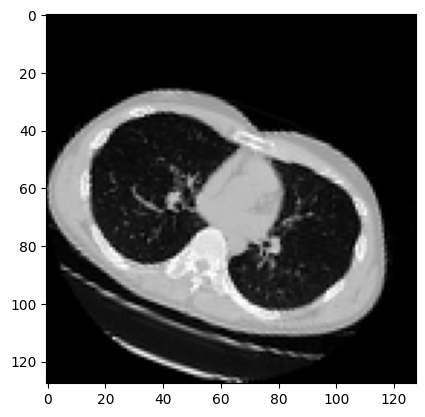

In [7]:
import matplotlib.pyplot as plt

data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")

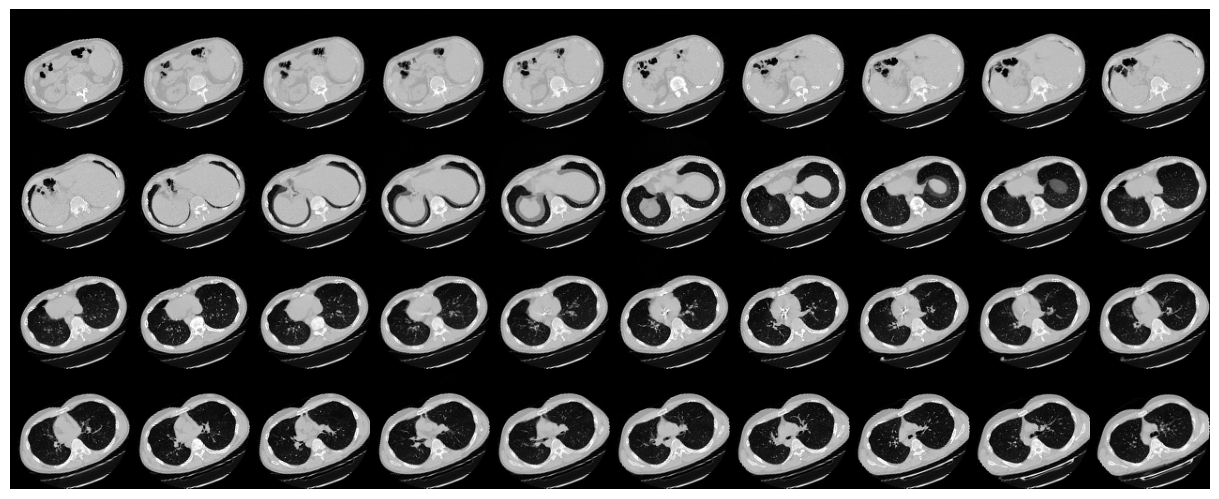

In [8]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the CT scan.
plot_slices(4, 10, 128, 128, image[:, :, :40])

# **Model Construction:**
Our CNN utilizes a a variety of hidden layers:
- 4x 3D Convolutional layers, each with a Pooling layer and a Batch-Normallization Layer.
- 1x Global Average Pooling Layer
- 1x Dense/Fully connected layer
- 1x Dropout layer

### Convolutional Layers:
Our convolution layers utilizing 64 3x3x3 kernels, or filters to extract feature maps. 
From here, to make processing easier, the MaxPooling layers will analyze these feature maps and extract the maximum value from the regions analyzed by the kernels to reduce the data and allow the model to focus on the critical areas of the data. 
Finally, the data goes through a batch normallization to ensure that the data is stable. These layers work by setting the variance of the incoming data to 1, and the mean to 0, which is similar to scaling our data, which improves the CNN's ability to generalize data better.
Our Convolutional layers also utilize ReLU activation functions to introduce non-linearity, which allows the CNN to learn more advanced data. 

We use 4 iterations of these Convolutional layers, increasing the filter size each time. This allows us to extract feature maps early on, and as the data propogates through the CNN, the greater number of filters allow it to be more specific.

### Global Average Pooling Layer: 
As the propagation finishes passing through the Convolutional layers, it takes the various feature maps from the convolutional layers and averages them to reduce their dimensionality from 3 to 1 dimension. This process can be thought of as summarizing the results of the Convolutional layers. 

### Dense Layer (ReLU):
Once the data is summarized by the Global Average Pooling Layer, the data is then processed by the fully connected layer. ReLU is employed again to ensure non-linearity so that the model can learn more complex patterns found in the summarized data. 

### Dense Layer (Sigmoid):
Since our dataset is set up to be a binary classification problem, we only need one output neuron. For the classifcation, we use a sigmoid activation function, outputting a value between 0 and 1. This represents a probability, denoting the model's confidence in the scan belonging to a particular class.

In [ ]:

def get_model(width=128, height=128, depth=64):
    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="Ct Scan CNN")
    return model


# Build model.
model = get_model(width=128, height=128, depth=64)
model.summary()

Model: "Ct Scan CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 64,   │             0 │
│                                 │ 1)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 126, 126, 62,   │         1,792 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 63, 63, 31, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 63, 63, 31, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 61, 61, 29, 64) │       110,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 30, 30, 14, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 30, 30, 14, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 28, 28, 12,     │       221,312 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 14, 14, 6, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 6, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 12, 12, 4, 256) │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 6, 6, 2, 256)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 2, 256)   │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling3d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling3D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,352,897 (5.16 MB)

 Trainable params: 1,351,873 (5.16 MB)

 Non-trainable params: 1,024 (4.00 KB)

# **Model Setup:**
We first set our learning rate to decrease gradually as the model training progresses. By doing this the model learns roughly first, but quickly, and fine-tunes later on. 

Next, we configure the optimizers for weight updating in backpropagation. We employ Adam due to its relatively good versatility (and because we are obligated to since one of our group members is named Adam) and minimal need for hyperparameter tuning.

We also create callbacks to save the model whenever the validation accuracy improves. Given how long it takes to train these models locally, this is an important step.

Finally, we train the model using the model.fit function.

In [ ]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
    run_eagerly=True,
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.keras", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model
epochs = 10
training = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/5
70/70 - 355s - 5s/step - acc: 0.5786 - loss: 0.6861 - val_acc: 0.5000 - val_loss: 0.7436
Epoch 2/5
70/70 - 355s - 5s/step - acc: 0.5929 - loss: 0.6617 - val_acc: 0.5000 - val_loss: 0.9104
Epoch 3/5
70/70 - 355s - 5s/step - acc: 0.6071 - loss: 0.6535 - val_acc: 0.5000 - val_loss: 1.0204
Epoch 4/5
70/70 - 356s - 5s/step - acc: 0.6214 - loss: 0.6561 - val_acc: 0.5000 - val_loss: 0.8065
Epoch 5/5
70/70 - 366s - 5s/step - acc: 0.6286 - loss: 0.6415 - val_acc: 0.6167 - val_loss: 0.6361


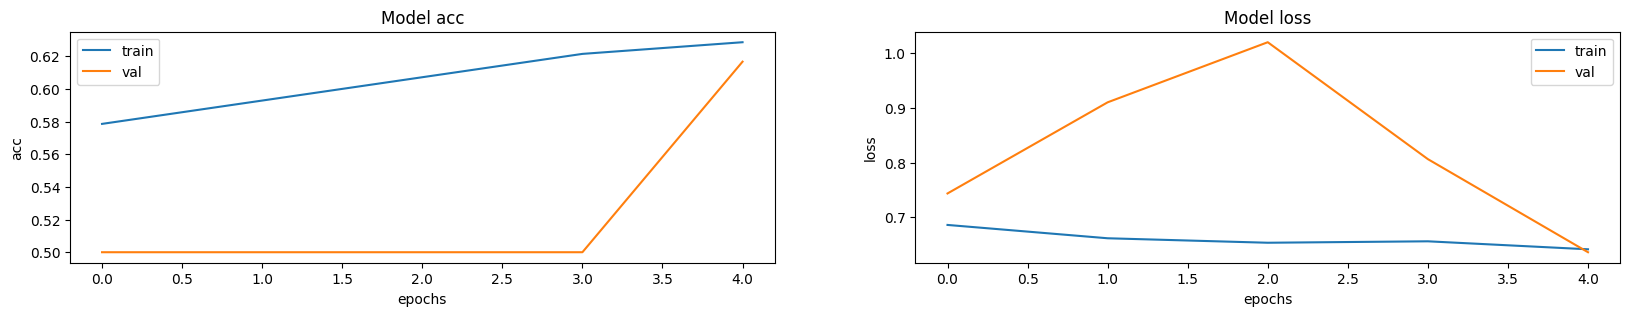

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [12]:
# Load best weights.
model.load_weights("3d_image_classification.keras")
y_pred = model.predict(np.expand_dims(x_test[0], axis=0))[0]
scores = [1 - y_pred[0], y_pred[0]]

class_names = ["normal", "abnormal"]
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that CT scan is %s"
        % ((100 * score), name)
    )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
This model is 55.20 percent confident that CT scan is normal
This model is 44.80 percent confident that CT scan is abnormal


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(x_test)
y_pred_c = np.argmax(y_pred, axis=1)
y_test_c = np.argmax(y_test, axis=1)
matrix_confusion = confusion_matrix(y_test_c, y_pred_c)

sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d', cbar=False )
plt.show()

1/2 ━━━━━━━━━━━━━━━━━━━━ 3:39 219s/step

In [ ]:
x = list(range(100))
vy = training.history['val_loss']
ty = training.history['loss']

plt.plot( x, vy )
plt.plot( x, ty )
plt.show()